Define a set of noise-contrastive learning paradigms which instantiate different types of word form codes.
Concretely, the negative sampling space defines the contrast set of relevant alternatives. A more modular word form code would sample broadly from the entire lexicon; a less modular word-form code would take into account contextual constraints that rule out many words in the lexicon.

These NCE objectives should impose constraints on the resulting optimal code.

---

Goal for this week: generate candidate NCE driven code and run an encoding analysis on HuBERT representations

In [1]:
from pathlib import Path

import h5py
import numpy as np
import pandas as pd
import torch
from torch import nn
from tqdm.auto import tqdm

import transformers

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
out_file = "word_encodings/nce.h5"

## Load corpus data

In [4]:
phone_df = pd.read_csv("timit_merged.csv")

In [5]:
# TODO duplicated from 01 autoencoding
# "Extra" phones in TIMIT not corresponding to speech sounds
timit_extras = ["pau", "epi", "h#"]

In [6]:
# NB different speakers will have different sentences and possibly different readings
# (e.g.  dropping words!) so a uniquely identifying key for a sentence transcript is
# (speaker, sentence_idx)
timit_word_df = phone_df[~phone_df.phone.isin(timit_extras)] \
    .groupby(["speaker", "sentence_idx", "word_idx"]).apply(lambda xs: xs.iloc[0].word)
timit_word_df.index = timit_word_df.index.set_levels(timit_word_df.index.levels[2].astype(int), level=2)
timit_word_df

speaker  sentence_idx  word_idx
FAEM0    SA1           0                she
                       1                had
                       2               your
                       3               dark
                       4               suit
                                     ...   
MZMB0    SX86          0           hispanic
                       1           costumes
                       2                are
                       3              quite
                       4           colorful
Length: 39823, dtype: object

In [7]:
timit_sentences_df = timit_word_df.groupby(["speaker", "sentence_idx"]).apply(lambda xs: xs.str.cat(sep=" "))
timit_sentences_df

speaker  sentence_idx
FAEM0    SA1             she had your dark suit in greasy wash water al...
         SA2                   don't ask me to carry an oily rag like that
         SI1392          assume for example a situation where a farm ha...
         SI2022                             what outfit does she drive for
         SI762                           fill small hole in bowl with clay
                                               ...                        
MZMB0    SX176           buying a thoroughbred horse requires intuition...
         SX266                     withdraw only as much money as you need
         SX356              diane may splurge and buy a turquoise necklace
         SX446             thomas thinks a larger clamp solves the problem
         SX86                         hispanic costumes are quite colorful
Length: 4620, dtype: object

## Load autoencoder

In [8]:
autoencoder = torch.load("autoencoder.pt")

In [9]:
from minicons import cwe, scorer
enc_model = cwe.CWE("distilgpt2")
score_model = scorer.IncrementalLMScorer("distilgpt2")

Using pad_token, but it is not set yet.
Using pad_token, but it is not set yet.


### Pre-compute encodings of GPT vocabulary

... just those words which appear in TIMIT, to make it easy to start

In [10]:
word_to_pronunciation = phone_df[~phone_df.phone.isin(timit_extras)] \
    .groupby(["dialect", "speaker", "sentence_idx", "word_idx", "word"]) \
    .apply(lambda xs: xs.phone.str.cat(sep=" ")) \
    .reset_index(["dialect", "speaker", "sentence_idx", "word_idx"], drop=True)
word_to_pronunciation = word_to_pronunciation.loc[~word_to_pronunciation.index.duplicated()].to_dict()

In [11]:
batch_size = 1
encoded_words = torch.zeros((enc_model.tokenizer.vocab_size,
                             autoencoder.encoder.hidden_size))
# Track which tokens are permitted as negative samples
vocab_mask = torch.zeros(enc_model.tokenizer.vocab_size, dtype=torch.bool)

timit_words_to_encode = list(word_to_pronunciation.keys())
timit_word_token_ids, token_id_to_timit_word = {}, {}
drop_timit_words = []
for word in tqdm(timit_words_to_encode):
    # add prefix space so that we get the BPE sentinel
    batch_idxs = enc_model.tokenizer(" " + word, return_tensors="pt", padding=True).input_ids
    # Extract just the first token ID
    gpt_vocab_idx = batch_idxs[0, 0].item()

    if gpt_vocab_idx in token_id_to_timit_word:
        # We've already encoded this word. This probably means that the earlier encoding
        # or this encoding is a subword of the other. We'll just skip it but make sure the
        # shortest encoding is retained.
        other_word = token_id_to_timit_word[gpt_vocab_idx]

        if len(word) < len(other_word):
            # This word is shorter, so we'll drop the other word
            drop_timit_words.append(other_word)
            token_id_to_timit_word[gpt_vocab_idx] = word
            timit_word_token_ids[word] = gpt_vocab_idx
            del timit_word_token_ids[other_word]
        else:
            # This word is longer, so we'll drop it
            drop_timit_words.append(word)

        continue

    # Encode the pronunciations
    pronunciation = word_to_pronunciation[word]
    with torch.no_grad():
        encoded_word, _ = autoencoder.encode(autoencoder.prepare_string(pronunciation))
    encoded_words[gpt_vocab_idx, :] = encoded_word

    vocab_mask[gpt_vocab_idx] = True
    timit_word_token_ids[word] = gpt_vocab_idx
    token_id_to_timit_word[gpt_vocab_idx] = word

  0%|          | 0/4891 [00:00<?, ?it/s]

### Pre-compute context encodings

In [12]:
def get_word_onset_token_idxs(words: list[str], sentence_batch_encoding: transformers.BatchEncoding):
    # tokenizer word id's don't always work how we expect -- so manually reconstruct this based on char_to_token
    # this array tracks the character onset of each word, including leading space if relevant
    word_onset_chars = np.array([len(word) for word in words])[:-1]
    word_onset_chars[1:] += 1
    word_onset_chars = np.concatenate([[0], word_onset_chars.cumsum()])
    
    batch_size = sentence_batch_encoding.input_ids.shape[0]
    
    # extract token idx of first token of each word
    word_onset_token_idxs = [
        sentence_batch_encoding.char_to_token(batch_size - 1, char_idx)
        for char_idx in word_onset_chars]
    token_idxs = [batch_enc.input_ids[batch_size - 1, idx]
                  for idx in word_onset_token_idxs]
    return token_idxs


if not Path("timit_encodings.h5").exists():
    with h5py.File("timit_encodings.h5", "w") as f:
        for idx, sentence in tqdm(timit_sentences_df.items(), total=len(timit_sentences_df)):
            words = sentence.split(" ")
            
            batch = [" ".join(words[:span]) for span in range(1, len(words) + 1)]

            batch_enc = enc_model.tokenizer(batch, padding=True, return_tensors="pt")

            # Extract GT token IDs for the first token of each word from the full sentence
            word_token_idxs = get_word_onset_token_idxs(words, batch_enc)
            gt_next_token = torch.stack(word_token_idxs[1:])
            # # Sanity check
            # print(sentence, enc_model.tokenizer.convert_ids_to_tokens(gt_next_token))

            sent_reps = enc_model.extract_sentence_representation(batch, 5)
            next_token_dist = score_model.next_word_distribution(batch)

            # Drop last item of batch. It is the final word in the sentence; we have no ground truth token
            sent_reps = sent_reps[:-1]
            next_token_dist = next_token_dist[:-1]

            assert sent_reps.shape[0] == gt_next_token.shape[0]
            assert next_token_dist.shape[0] == gt_next_token.shape[0]
            
            h5_key = "/".join(idx) if isinstance(idx, tuple) else idx
            f[f"{h5_key}/representations"] = sent_reps.numpy()
            f[f"{h5_key}/next_token_dist"] = next_token_dist.numpy()
            f[f"{h5_key}/gt_next_token"] = gt_next_token.numpy()

In [13]:
# Check that word count in h5 matches word count in TIMIT
any_count_mismatches = False
with h5py.File("timit_encodings.h5", 'r') as f:
    # Iterate keys two levels deep
    keys = [(subject, sentence)
            for subject in f.keys()
            for sentence in f[subject].keys()]
    for subject, sentence in tqdm(keys):
        h5count = len(f[subject][sentence]["representations"])

        timitcount = timit_word_df.loc[(subject, sentence)].shape[0]
        if not h5count + 1 == timitcount:
            print(f"{idx}: {h5count} + 1 != {timitcount}")
            any_count_mismatches = True

if any_count_mismatches:
    assert False, "Some sentences have mismatched word counts"

  0%|          | 0/4620 [00:00<?, ?it/s]

In [14]:
# Flatten data representation
all_ids = []
all_representations = []
all_next_token_dist = []
all_gt_token = []

# Prepare to filter some examples. If `True` then retain.
filter_examples = []

with h5py.File("timit_encodings.h5", "r") as f:
    # Iterate keys two levels deep
    keys = [(subject, sentence)
            for subject in f.keys()
            for sentence in f[subject].keys()]
    for key in tqdm(keys):
        h5_key = "/".join(key) if isinstance(key, tuple) else key
        num_words = f[f"{h5_key}/representations"].shape[0]

        retain_words = ~timit_word_df.loc[key].iloc[1:].isin(drop_timit_words)
        filter_examples.append(retain_words.to_numpy())

        # First word of each sequence was dropped in representation extraction
        all_ids.append(np.array([(*key, str(i + 1)) for i in range(num_words)]))
        all_representations.append(f[f"{h5_key}/representations"][()])
        all_next_token_dist.append(f[f"{h5_key}/next_token_dist"][()])
        all_gt_token.append(f[f"{h5_key}/gt_next_token"][()])
        # all_source_idx.append([(idx, i) for i in range(len(f[f"{idx}/gt_token"]))])

all_ids = np.concatenate(all_ids)
all_representations = np.concatenate(all_representations)
all_next_token_dist = np.concatenate(all_next_token_dist)
all_gt_token = np.concatenate(all_gt_token)
filter_examples = np.concatenate(filter_examples)

  0%|          | 0/4620 [00:00<?, ?it/s]

In [15]:
filter_examples.shape, all_ids.shape, all_representations.shape

((35203,), (35203, 3), (35203, 768))

In [16]:
# Filter out words that are not in the TIMIT vocabulary
filter_examples = filter_examples & vocab_mask[all_gt_token].numpy()
all_ids = all_ids[filter_examples]
all_representations = all_representations[filter_examples]
all_next_token_dist = all_next_token_dist[filter_examples]
all_gt_token = all_gt_token[filter_examples]

In [17]:
all_ids.shape, all_representations.shape, all_next_token_dist.shape, all_gt_token.shape

((33887, 3), (33887, 768), (33887, 50257), (33887,))

## Model setup

In [18]:
from models.nce import NCERankerModel, NCELoss

In [19]:
negative_samples = 30
hidden_size = 128

ranker = NCERankerModel(autoencoder.encoder.hidden_size,
                        all_representations.shape[1],
                        hidden_size)
embedding = nn.Embedding.from_pretrained(encoded_words.clone(), freeze=True)
loss = NCELoss(ranker, embedding, negative_samples,
               vocab_mask=vocab_mask)

In [20]:
def encode_all(ranker, embedding_model, batch_size=32):
    all_encodings = []
    for i in tqdm(range(0, len(all_representations), batch_size)):
        context_batch = torch.from_numpy(all_representations[i:i+batch_size])
        embedding_batch = embedding_model(torch.from_numpy(all_gt_token[i:i+batch_size]))
        with torch.no_grad():
            all_encodings.append(ranker.encode(context_batch, embedding_batch).numpy())

    return np.concatenate(all_encodings)

def forward_batch(ranker, loss, batch_size=32):
    batch_idxs = np.random.choice(len(all_representations), batch_size)
    batch_representations = torch.from_numpy(all_representations[batch_idxs])
    batch_next_token_dist = torch.from_numpy(all_next_token_dist[batch_idxs])
    batch_gt_token = torch.from_numpy(all_gt_token[batch_idxs])

    return loss(batch_representations, batch_gt_token, batch_next_token_dist)

In [21]:
losses = []
optim = torch.optim.Adam(loss.parameters(), lr=1e-3, weight_decay=1e-3)

for i in range(200):
    optim.zero_grad()

    batch_loss = forward_batch(ranker, loss)
    batch_loss.backward()

    # if i % 20 == 0:
    #     for name, param in loss.named_parameters():
    #         print(name, param.grad.abs().sum().item())

    optim.step()

    if i % 20 == 0:
        print(f"{i} {batch_loss.item():.3f}")
    losses.append(batch_loss.item())

0 3.813
20 0.353
40 0.152
60 0.157
80 0.147
100 0.145
120 0.146
140 0.145
160 0.144
180 0.141


## Compute and export encodings

In [22]:
# Extract context-sensitive encodings of each word token
final_encodings = encode_all(ranker, embedding)

  0%|          | 0/1059 [00:00<?, ?it/s]

In [23]:
with h5py.File(out_file, "w") as f:
    assert all_ids.shape[0] == final_encodings.shape[0]
    f["ids"] = all_ids.astype("S")
    f["encodings"] = final_encodings

### Compute and export autoencoder encodings

TODO: this should happen in the autoencoder notebook

In [24]:
with h5py.File("word_encodings/autoencoder.h5", "w") as f:
    assert all_ids.shape[0] == final_encodings.shape[0]
    f["ids"] = all_ids.astype("S")
    f["encodings"] = np.array([
        encoded_words[gpt_vocab_idx].numpy()
        for gpt_vocab_idx in all_gt_token
    ])

## Visualize

In [25]:
# Group encodings by GT token
timit_encodings_final = {}
for i, (speaker, sentence_idx, token) in enumerate(all_ids):
    timit_word = token_id_to_timit_word[all_gt_token[i]]
    if timit_word not in timit_encodings_final:
        timit_encodings_final[timit_word] = []
    timit_encodings_final[timit_word].append(final_encodings[i])

In [26]:
from collections import Counter
Counter({w: len(vs) for w, vs in timit_encodings_final.items()})

Counter({'to': 1004,
         'the': 996,
         'in': 904,
         'a': 723,
         'that': 583,
         'your': 563,
         'an': 556,
         'all': 538,
         'had': 526,
         'me': 516,
         'like': 514,
         'water': 479,
         'and': 479,
         'dark': 473,
         'year': 473,
         'oily': 470,
         'rag': 470,
         'wash': 469,
         'ask': 464,
         'carry': 463,
         'suit': 462,
         'greasy': 462,
         'of': 444,
         'is': 395,
         'you': 242,
         'was': 231,
         'are': 225,
         'for': 207,
         'with': 180,
         'be': 168,
         'on': 164,
         'his': 138,
         'it': 129,
         'he': 128,
         'from': 122,
         'by': 122,
         'have': 120,
         'not': 112,
         'this': 108,
         'her': 105,
         'as': 101,
         'will': 86,
         'him': 84,
         'or': 75,
         'were': 73,
         'up': 68,
         'but': 68,
         'new

### Average within-word

In [28]:
timit_word_list = list(timit_encodings_final.keys())
timit_encodings_final_avg = {
    timit_word: np.mean(np.array(encodings), axis=0)
    for timit_word, encodings in timit_encodings_final.items()
}
timit_encodings_final_avg = [timit_encodings_final_avg[w] for w in timit_word_list]

In [29]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(2).fit(timit_encodings_final_avg)
timit_encodings_pca = pca.transform(timit_encodings_final_avg)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:
pca.explained_variance_ratio_

array([0.80181388, 0.17569572])

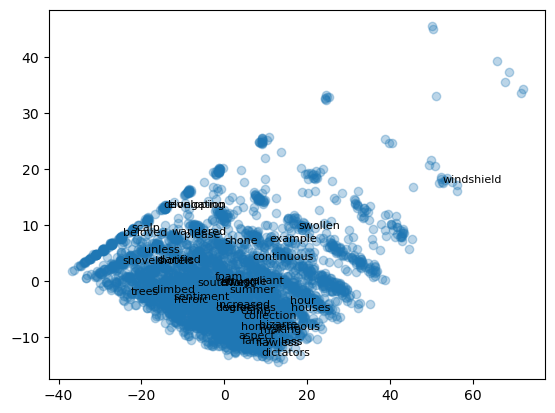

In [31]:
plt.scatter(timit_encodings_pca[:, 0], timit_encodings_pca[:, 1], alpha=0.3)

# sample_ps = val_data.dataset.tensors[1][val_data.indices].float().numpy()
# sample_ps /= sample_ps.sum()
for idx in np.random.choice(len(timit_encodings_pca), size=40, replace=False):
    plt.text(timit_encodings_pca[idx, 0], timit_encodings_pca[idx, 1],
             timit_word_list[idx], fontdict={"fontsize": 8})

### Plot just words with same prefix

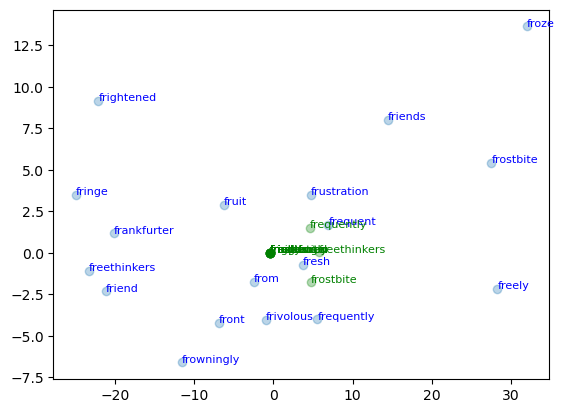

In [32]:
plot_mask = np.array([i for i, word in enumerate(timit_word_list) if word.startswith("fr")])

plot_data = timit_encodings_pca[plot_mask]
# plot_data = PCA(2).fit_transform(timit_encodings[plot_mask])
baseline_data = PCA(2).fit_transform(encoded_words.numpy())[plot_mask]

plt.scatter(plot_data[:, 0], plot_data[:, 1], alpha=0.3)
plt.scatter(baseline_data[:, 0], baseline_data[:, 1], alpha=0.3, c="green")

plot_words = np.array(timit_word_list)[plot_mask]
for idx in np.random.choice(len(plot_data), size=min(len(plot_data), 40), replace=False):
    plt.text(plot_data[idx, 0], plot_data[idx, 1],
             plot_words[idx], fontdict={"fontsize": 8}, c="blue")
    plt.text(baseline_data[idx, 0], baseline_data[idx, 1],
             plot_words[idx], fontdict={"fontsize": 8}, c="green")

### Visualize distances

In [33]:
from scipy.spatial.distance import pdist, squareform

item_distances = squareform(pdist(timit_encodings_final_avg))
item_distances = pd.DataFrame(item_distances)
# Keep just the upper triangle, not including diagonal
item_distances = item_distances.where(np.triu(np.ones(item_distances.shape), k=1).astype(bool))
item_distances.index = timit_word_list
item_distances.columns = timit_word_list
item_distances = item_distances.stack().dropna()
item_distances = item_distances.sort_values()

In [34]:
item_distances.head(20)

prescription  superiors       0.390287
frightened    filtered        0.390310
particular    portrayal       0.390386
annoying      revolution      0.391641
guerrilla     golfing         0.393190
sculptor      simplest        0.396740
manufacturer  antigen         0.406301
cigarettes    orchestra       0.425409
lady's        cowboy          0.432574
greeted       smiled          0.433656
cigarettes    beatniks        0.439344
triumphant    avalanche       0.446212
frightened    former          0.454897
toddler       cartoon         0.463887
cartoon       connoisseur     0.471601
cigarettes    injected        0.475971
response      giant           0.476314
misprint      opposing        0.480145
mango         cowboy          0.480461
preschooler   prescription    0.484643
dtype: float64

In [35]:
item_distances.tail(20)

foreigners   items          110.217861
spurs        differently    110.227893
ray          foreigners     110.318303
tycoons      foreigners     110.556036
foreigners   reached        110.615292
spurs        foreigners     110.736081
differently  organism       110.797426
chaw         differently    110.921988
differently  bristles       110.975745
wealthy      irritated      110.988031
foreigners   organism       111.299681
differently  stock          111.393694
chaw         foreigners     111.427593
foreigners   bristles       111.478640
sailboat     irritated      111.502386
foreigners   stock          111.892358
wealthy      differently    112.552139
             foreigners     113.050730
sailboat     differently    113.081583
             foreigners     113.586535
dtype: float64